# **1D Heat Equation**

The **1D Heat Equation** is given by:

$$
\frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} = 0, \quad x \in [0,1], \quad t \in [0,1]
$$

with the **initial condition**:

$$
u(x,0) = \sin(\pi x)
$$

and **boundary conditions**:

$$
u(0,t) = 0, \quad u(1,t) = 0
$$

where **α** is the **diffusion coefficient**.


The **analytical solution** using the method of **separation of variables** is:

$$
u(x,t) = e^{-\alpha \pi^2 t} \sin(\pi x)
$$


In [50]:
# !pip install torch torchvision torchaudio

In [3]:
import torch
import torch.nn as nn
print(torch.__version__)
import numpy as np

2.6.0


## Define the PINN Model

In [4]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)  # Combine x and t as input
        return self.net(inputs)

## Define the PDE residual loss

In [5]:
def pde_residual(x, t, model, alpha=0.01):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    return u_t - alpha * u_xx

## Initialize model and optimizer

In [6]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [11]:
for epoch in range(5000):
    optimizer.zero_grad()
    
    # Sample collocation points in the domain
    x_collocation = torch.rand(100, 1)
    t_collocation = torch.rand(100, 1)
    
    loss_pde = torch.mean(pde_residual(x_collocation, t_collocation, model) ** 2)

    # Enforce boundary conditions
    x_bc = torch.cat([torch.zeros(50, 1), torch.ones(50, 1)], dim=0)
    t_bc = torch.rand(100, 1)
    u_bc = torch.zeros_like(x_bc)
    loss_bc = torch.mean((model(x_bc, t_bc) - u_bc) ** 2)

    # Enforce initial condition
    x_ic = torch.rand(100, 1)
    t_ic = torch.zeros_like(x_ic)
    u_ic = torch.sin(np.pi * x_ic)
    loss_ic = torch.mean((model(x_ic, t_ic) - u_ic) ** 2)

    # Total loss
    loss = loss_pde + loss_bc + loss_ic
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 7.088713573466521e-06
Epoch 500, Loss: 1.300014992011711e-05
Epoch 1000, Loss: 8.02320209913887e-06
Epoch 1500, Loss: 2.734058944042772e-05
Epoch 2000, Loss: 2.2628013539360836e-05
Epoch 2500, Loss: 0.00015192048158496618
Epoch 3000, Loss: 4.946115950588137e-06
Epoch 3500, Loss: 7.22022832633229e-06
Epoch 4000, Loss: 5.468468316394137e-06
Epoch 4500, Loss: 1.2220358257764019e-05


In [19]:
x_test = torch.linspace(0, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')  # Create a grid

In [20]:
X_flat = X.reshape(-1, 1)
T_flat = T.reshape(-1, 1)

## Evaluate the trained model

In [21]:
with torch.no_grad():
    U_flat = model(X_flat, T_flat)
U = U_flat.reshape(100, 100).numpy()  # Reshape into a 100x100 matrix

In [32]:
print("Minimum value of U:", U.min())

Minimum value of U: -0.002613278


In [24]:
negative_values = U[U < 0]
print("Negative values in U:", negative_values)

Negative values in U: [-2.2264197e-05 -5.1574782e-05 -7.8516081e-05 -1.0323711e-04
 -1.2584217e-04 -1.4612265e-04 -1.6457029e-04 -1.8121488e-04
 -1.9590743e-04 -2.0890124e-04 -2.2019632e-04 -2.2992678e-04
 -2.3812242e-04 -2.4491735e-04 -2.5026686e-04 -2.5431998e-04
 -2.5713630e-04 -2.5887974e-04 -2.5937147e-04 -2.5882013e-04
 -2.5725551e-04 -2.5479682e-04 -2.5125034e-04 -2.4709292e-04
 -2.4216063e-04 -2.3630448e-04 -2.2964366e-04 -2.2268482e-04
 -2.1469779e-04 -2.0624883e-04 -1.9726343e-04 -1.8766709e-04
 -1.7766841e-04 -1.6719289e-04 -1.5625544e-04 -1.4488585e-04
 -1.3320334e-04 -1.2122281e-04 -1.0869093e-04 -9.6084550e-05
 -8.3046034e-05 -6.9709495e-05 -5.6089833e-05 -4.2291358e-05
 -2.8403476e-05 -1.4157966e-05 -6.2401779e-04 -7.1741827e-04
 -8.0762990e-04 -8.9471228e-04 -9.7908266e-04 -1.0601748e-03
 -1.1388529e-03 -1.2145955e-03 -1.2877304e-03 -1.3582278e-03
 -1.4260877e-03 -1.4916379e-03 -1.5545357e-03 -1.6150046e-03
 -1.6733129e-03 -1.7294008e-03 -1.7831344e-03 -1.8346626e-03
 -

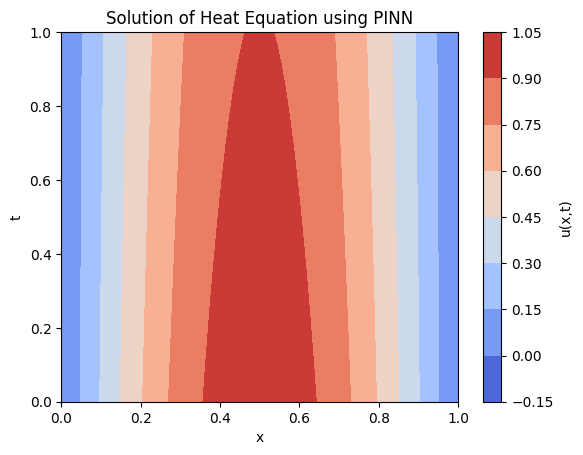

In [22]:
import matplotlib.pyplot as plt

plt.contourf(X.numpy(), T.numpy(), U, cmap="coolwarm")
plt.colorbar(label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Solution of Heat Equation using PINN")
plt.show()

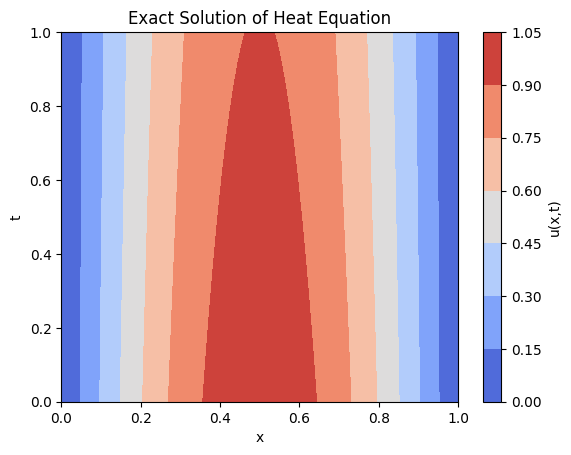

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define x and t values
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

# Compute the exact solution
alpha = 0.01  # Diffusion coefficient
U_exact = np.exp(-alpha * np.pi**2 * T) * np.sin(np.pi * X)

# Plot the exact solution
plt.contourf(X, T, U_exact, cmap="coolwarm")
plt.colorbar(label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Exact Solution of Heat Equation")
plt.show()


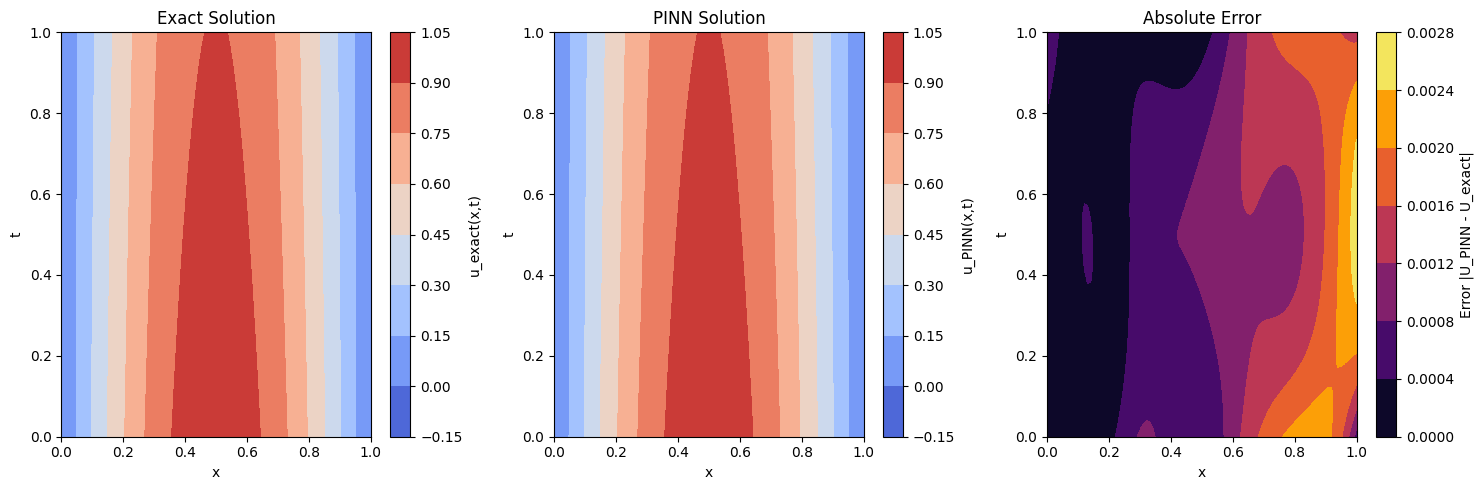

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the exact solution of the 1D heat equation
def exact_solution(x, t, alpha=0.01):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

# Generate test data (x, t)
x_test = torch.linspace(0, 1, 100)
t_test = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x_test, t_test, indexing='ij')  # Meshgrid

# Convert to 1D for model input
X_flat = X.reshape(-1, 1)
T_flat = T.reshape(-1, 1)

# Evaluate PINN model on (x, t) grid
with torch.no_grad():
    U_PINN_flat = model(X_flat, T_flat)  # PINN output
U_PINN = U_PINN_flat.reshape(100, 100).numpy()  # Reshape for plotting

# Compute the exact solution
U_exact = exact_solution(X.numpy(), T.numpy())

# Compute the absolute error |U_PINN - U_exact|
error = np.abs(U_PINN - U_exact)

# Plot PINN Solution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.contourf(X.numpy(), T.numpy(), U_exact, cmap="coolwarm")
plt.colorbar(label="u_exact(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Exact Solution")

# Plot PINN Solution
plt.subplot(1, 3, 2)
plt.contourf(X.numpy(), T.numpy(), U_PINN, cmap="coolwarm")
plt.colorbar(label="u_PINN(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Solution")

# Plot Error |U_PINN - U_exact|
plt.subplot(1, 3, 3)
plt.contourf(X.numpy(), T.numpy(), error, cmap="inferno")
plt.colorbar(label="Error |U_PINN - U_exact|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Absolute Error")

# Show the plots
plt.tight_layout()
plt.show()


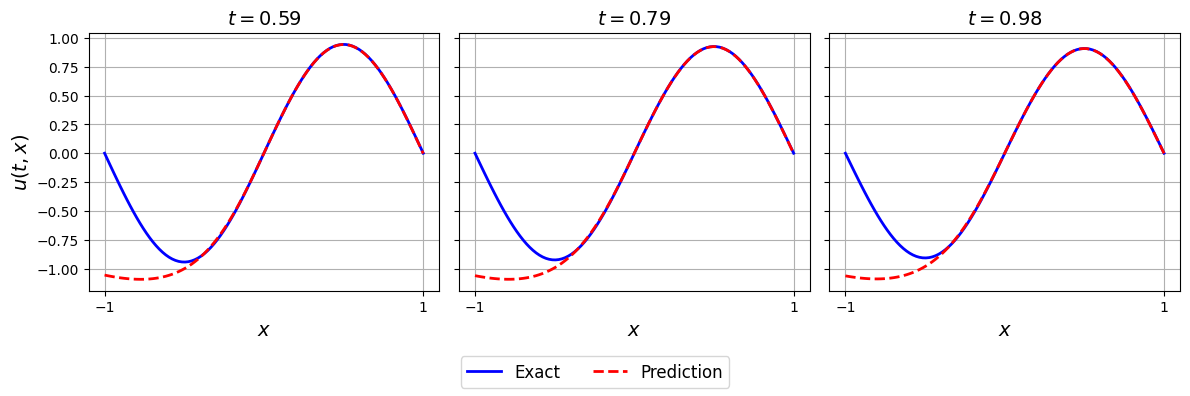

In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the exact solution function
def exact_solution(x, t, alpha=0.01):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

# Generate x values
x_test = torch.linspace(-1, 1, 100)  # Adjust the range if needed

# Choose specific time snapshots
time_snapshots = [0.59, 0.79, 0.98]

# Create subplots
fig, axes = plt.subplots(1, len(time_snapshots), figsize=(12, 4), sharey=True)

# Loop through each time snapshot
for i, t in enumerate(time_snapshots):
    t_fixed = torch.full_like(x_test, t)  # Create a tensor of the same shape with fixed time
    
    # Evaluate the PINN model at (x, t)
    with torch.no_grad():
        u_pred = model(x_test.view(-1, 1), t_fixed.view(-1, 1)).numpy().flatten()
    
    # Compute exact solution
    u_exact = exact_solution(x_test.numpy(), t)

    # Plot exact solution
    axes[i].plot(x_test.numpy(), u_exact, 'b-', linewidth=2, label="Exact")  # Blue solid line
    
    # Plot PINN predicted solution
    axes[i].plot(x_test.numpy(), u_pred, 'r--', linewidth=2, label="Prediction")  # Red dashed line
    
    # Labels and titles
    axes[i].set_title(r"$t = %.2f$" % t, fontsize=14)
    axes[i].set_xlabel(r"$x$", fontsize=14)
    axes[i].set_xticks([-1, 1])  # Adjust x-axis ticks for clarity
    
    if i == 0:
        axes[i].set_ylabel(r"$u(t,x)$", fontsize=14)  # Label for y-axis (only on the first plot)
    
    axes[i].grid(True)

# Add legend below the plots
fig.legend(["Exact", "Prediction"], loc="lower center", ncol=2, fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


In [35]:
print("Minimum value of U:", u_pred.min())

Minimum value of U: -1.0896004


In [36]:
negative_values = u_pred[u_pred < -1]
print("Negative values in U:", negative_values)

Negative values in U: [-1.0632203 -1.0679903 -1.072365  -1.0763183 -1.0798218 -1.0828459
 -1.0853589 -1.0873275 -1.0887161 -1.089487  -1.0896004 -1.0890145
 -1.0876845 -1.0855632 -1.0826015 -1.0787469 -1.0739448 -1.0681374
 -1.061265  -1.0532647 -1.0440713 -1.0336175 -1.0218337 -1.0086486]


In [37]:
u_pred.shape

(100,)

In [ ]:
with torch.no_grad():
        u_pred = model(x_test.view(-1, 1), t_fixed.view(-1, 1)).numpy().flatten()

In [40]:
with torch.no_grad():
    U_flat = model(X_flat, T_flat)
U = U_flat.reshape(100, 100).numpy()  # Reshape into a 100x100 matrix

In [42]:
U.shape

(100, 100)

In [14]:
# x_test = torch.linspace(0, 1, 100).view(-1, 1)
# t_fixed = torch.full_like(x_test, 0.5)  # Shape (100, 1), all values = 0.5

# # Evaluate the model at (x, t=0.5)
# with torch.no_grad():
#     u_pred = model(x_test, t_fixed).numpy()  # Shape (100, 1)

# import matplotlib.pyplot as plt

# # Plot x vs. u(x) at t = 0.5
# plt.plot(x_test.numpy(), u_pred, label="u(x) at t=0.5", color="b")

# # Labels and title
# plt.xlabel("x")
# plt.ylabel("u(x)")
# plt.title("Solution at t = 0.5")
# plt.legend()
# plt.grid(True)

# # Show plot
# plt.show()

# Visualize the Solution

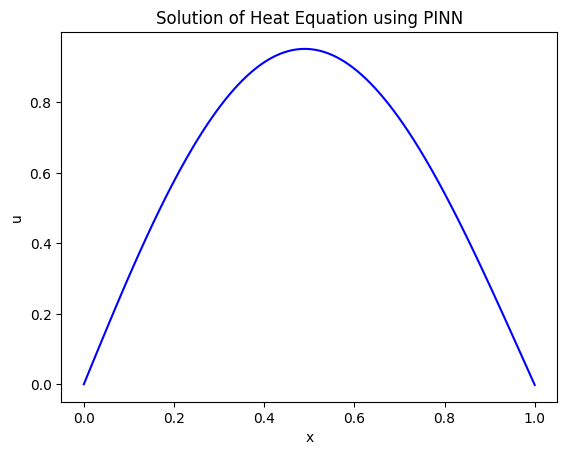

In [18]:
import matplotlib.pyplot as plt

# X, T = np.meshgrid(x_test.numpy(), t_test.numpy())
# U = u_pred.reshape(100, 100)

plt.plot(x_test.numpy(), u_pred, label="u(x) ", color="b")
# plt.colorbar(label="u(x,t)")
plt.xlabel("x")
plt.ylabel("u")
plt.title("Solution of Heat Equation using PINN")
plt.show()